# **Intro**

In [ ]:
# Importing general library

import os
import random
import pickle
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

# **Functions**

In [ ]:
# Reset random seed

def reset_random_seeds(seed_value=1):
   os.environ['PYTHONHASHSEED']=str(seed_value)
   tf.random.set_seed(seed_value)
   np.random.seed(seed_value)
   random.seed(seed_value)

In [ ]:
# Date-time Parsing

def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')

In [ ]:
# Inverse scaling function

def inverse_scaling(series, scaler):
  temp = np.zeros((len(series), 5))
  temp[:, -1] = series.reshape(len(series))
  temp = scaler.inverse_transform(temp)
  inverted = temp[:, -1]
  return inverted

In [ ]:
# Differencing

def difference(data, times=1):
  data_diff = data.diff()
  data_diff.dropna(inplace=True)
  if times == 0:
    return data
  elif times == 1:
    return data_diff
  else:
    for i in range(0,times-1):
      data_diff = data_diff.diff()
      data_diff.dropna(inplace=True)
    return data_diff

In [ ]:
# Inverse difference

def inverse_difference(series, differenced, times_diff):
  for n in range(1,times_diff+1):
    inverted = list()
    seed = difference(series,times_diff-n)[-1]
    inverted.append(seed)
    for i in range(len(differenced)):
	    value = inverted[i] + differenced[i]
	    inverted.append(value)
    differenced = pd.Series(inverted[1:].copy())
  inverted_difference = differenced.copy()
  return inverted_difference

# **Load files**

In [ ]:
# Title
title = "Thailand Covid-19 Confirmed Cases"

# Load dataset
data_path = '/content/thailand_covid_19_confirmed_cases.csv'
dataset = pd.read_csv(data_path, date_parser=parser, parse_dates=[0])
# Replace index with datetime
dataset = dataset.set_index('Date')
# Change from dataframe to series
dataset = pd.Series(dataset.values.flatten(), index=dataset.index)

# Load supervised values
supervised_values_path = '/content/thailand_covid_19_confirmed_cases_supervised_values.csv'
supervised_dataframe = pd.read_csv(supervised_values_path, date_parser=parser, parse_dates=[0])
# Replace index with datetime
supervised_dataframe = supervised_dataframe.set_index('Date')
# Get values
supervised_values = supervised_dataframe.values

# Load scaler
scaler_path = '/content/thailand-covid-19-confirmed-cases-scaler.pkl'
scaler = pickle.load(open(scaler_path, 'rb'))

# Load model
model_path = '/content/thailand-covid-19-confirmed-cases-model.h5'
model = tf.keras.models.load_model(model_path)

# **Input**

In [ ]:
# Input date

start_date = '2020-02-01'
end_date = '2020-08-30'

# **Process**

In [ ]:
# Convert input to datetime object

start_date = datetime.strptime(start_date, '%Y-%m-%d')
end_date = datetime.strptime(end_date, '%Y-%m-%d')

In [ ]:
# Limit (last date from dataset)

limit_date = datetime(2020,7,28)

In [ ]:
# Check available date

out_of_range = False
if start_date >= limit_date:
  print("Your request is out of range, we will predict some data for you!")
  out_of_range = True
else:
  desired_dates = pd.date_range(start_date,end_date)
  for desired_date in desired_dates:
    if desired_date >= limit_date:
      print("Your request is out of range, we will predict some data for you!")
      out_of_range = True
      break

Your request is out of range, we will predict some data for you!


## **Forecasting (if needed)**

In [ ]:
if out_of_range:
  # Scaling
  devide_border = int(0.8*(len(supervised_values)))
  supervised_values_head = supervised_values[:devide_border]
  supervised_values_tail = supervised_values[devide_border:]
  supervised_values_head = scaler.transform(supervised_values_head)
  supervised_values_tail = scaler.transform(supervised_values_tail)
  supervised_values_scaled = np.append(supervised_values_head, supervised_values_tail, axis=0)

  # Feature-label split
  feature, label = supervised_values_scaled[:, 0:-1], supervised_values_scaled[:, -1]

  # Feature reshape
  feature_reshaped = np.reshape(feature, (feature.shape[0], 2, 2, 1))

  # Make feature and label history
  feature_history = feature_reshaped
  label_history = label

In [ ]:
# Rolling predict

if out_of_range:
  predictions = np.array([])
  n = len(pd.date_range(limit_date,end_date))
  for i in range(n+1):
    # Train after first iteration
    if i > 0:
      reset_random_seeds()
      model.fit(feature_history, label_history, epochs=10, verbose=0)
    # Forecasting
    forecast = model.predict(np.array([feature_history[-1]]), verbose=0)
    # Append result to feature history for re-train
    temp = np.append(feature_history[-1].flatten()[1:], label_history[-1]).reshape((1,2,2,1))
    feature_history = np.append(feature_history, temp, axis=0)
    # Append result to label history for re-train
    label_history = np.append(label_history, forecast)
    # Collect predictions
    predictions = np.append(predictions, forecast)
  predictions = predictions[1:]

In [ ]:
# Inverse predictions to original values

if out_of_range:
  # Inverse scaling
  predictions = inverse_scaling(predictions, scaler)
  # Inverse difference
  predictions = inverse_difference(dataset, predictions, 2)
  # Index = datetime
  predictions.index = pd.date_range(limit_date,end_date)

# **Output**

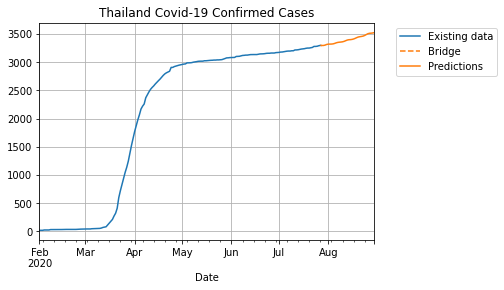

In [ ]:
# Show predictions plot

if out_of_range:
  if start_date >= limit_date:
    # Get data
    desired_data = predictions[start_date:]
    # Plot
    predictions[start_date:].plot(label='Predictions', c='tab:orange')
  else:
    # Get data
    desired_data = dataset[start_date:].append(predictions)
    # Plot
    bridge_index = [dataset.index[-1],predictions.index[0]]
    bridge = pd.Series([dataset[-1],predictions[0]], index=bridge_index)
    dataset[start_date:].plot(label='Existing data', c='tab:blue')
    bridge.plot(label='Bridge', ls='--',c='tab:orange')
    predictions.plot(label='Predictions', c='tab:orange')
else:
  # Get data
  desired_data = dataset[start_date:end_date]
  # Plot
  dataset[start_date:end_date].plot(label='Existing data', c='tab:blue')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(title)
plt.grid(True)
plt.show()

In [ ]:
# pd.set_option('display.max_rows', None)
desired_data
# pd.reset_option('all')

2020-02-01      19.000000
2020-02-02      19.000000
2020-02-03      19.000000
2020-02-04      25.000000
2020-02-05      25.000000
                 ...     
2020-08-26    3504.418575
2020-08-27    3511.755048
2020-08-28    3513.716564
2020-08-29    3517.438572
2020-08-30    3523.319014
Length: 212, dtype: float64